### 2 Route Data Review

#### 2.0 Data Description

The next step after downloading the data is to analyse the route data; we need to know where the buses *should* be.

You can review XML feed documention here https://www.nextbus.com/xmlFeedDocs/NextBusXMLFeed.pdf

The five tables we will look at are:
* **tbl_ttc_route** (from routeConfig feed, route data) -- basic info about the route
* **tbl_ttc_route_stop** (from routeConfig feed, stop data) -- location of route stops
* **tbl_ttc_dir** (from routeConfig, direction data) -- unique list of route directions
* **tbl_ttc_dir_stop** (from routeConfig feed, direction data) -- list of stops/names on each route for each direction
* **tbl_ttc_route_path** (from routeConfig feed, path data) -- each path is list of points that can be used to draw the route on a map.. paths can be overlapping, and are not in order



In [130]:
#import helperfunction.py
%run helperfunctions

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import psycopg2
db = db_name

from descartes import PolygonPatch
import tilemapbase
from textwrap import wrap

#uncomment if you want to analyse a different database from the one in your settings file
#db = 'ttctestii'


#### 2.1 tbl_ttc_route

Looks like *tag* is the route number and the *title* is the name of the route.  I'm guessing lat min/max and lon min/max would be used to size a map if you wanted to map the route.  

In [2]:
tbl = 'tbl_ttc_route'
df_route = gettbl(tbl,db)
df_route.head()

,color,latmax,latmin,lonmax,lonmin,oppositecolor,tag,title
0,ff0000,43.7062,43.6564699,-79.38679,-79.40607,ffffff,5,5-Avenue Road
1,ff0000,43.6761799,43.64155,-79.36537,-79.40194,ffffff,6,6-Bay
2,ff0000,43.79256,43.6660599,-79.41106,-79.44745,ffffff,7,7-Bathurst
3,ff0000,43.6976099,43.6766899,-79.32923,-79.35861,ffffff,8,8-Broadview
4,ff0000,43.7805499,43.7109799,-79.2297099,-79.28063,ffffff,9,9-Bellamy


#### 2.2 tbl_ttc_route_stop

This shows the position (lat/lon) of each stop along with the route tag which should match back to the route table

In [3]:
tbl = 'tbl_ttc_route_stop'
df_route_stop = gettbl(tbl,db)
df_route_stop.head()

,oid,lat,lon,stopid,tag,title,routetag
0,0,43.7056499,-79.39986,14668,14189,Eglinton Station,5
1,1,43.7062,-79.4013099,2360,4420,Eglinton Ave West At Henning Ave,5
2,2,43.70573,-79.4035599,2375,10274,Eglinton Ave West At Lascelles Blvd,5
3,3,43.7046499,-79.40607,10788,9489,Oriole Pkwy At Eglinton Ave West South Side,5
4,4,43.7021299,-79.4050599,10789,8205,Oriole Pkwy At College View Ave South Side,5


#### 2.3 tbl_ttc_dir

This shows the different directions or versions of each line, eg. the 32 route has the 'A', 'C' and 'D' variants.  And each of the variants would have separate directions. The *tag* field shows the unique identifier of each direction variant.. the format is routetag_direction_variant

In [4]:
tbl = 'tbl_ttc_dir'
df_dir = gettbl(tbl,db)
#df_dir.head()
df_dir.loc[df_dir['routetag']=='32']

,branch,name,tag,title,useforui,routetag
63,32D,West,32_1_32D,West - 32d Eglinton West towards Jane & Emmett,true,32
64,32S,West,32_1_32ke,West - 32s Eglinton West Short Turn towards Keele,true,32
65,32D,East,32_0_32D,East - 32d Eglinton West towards Eglinton West...,true,32
66,32C,West,32_1_32C,West - 32c Eglinton West towards Jane & Lawren...,true,32
67,32,East,32_0_32C,East - 32 Eglinton West towards Eglinton Station,true,32
68,32A,West,32_1_32A,West - 32a Eglinton West towards Renforth Station,true,32
69,32,East,32_0_32A,East - 32 Eglinton West towards Eglinton Station,true,32


#### 2.4 tbl_ttc_dir_stop

*routetag* and *directiontag* match to the *routetag* and *tag* columns in the dir table.  *tag* would appear to match to the *tag* column in the route stop table.

In [5]:
tbl = 'tbl_ttc_dir_stop'
df_dir_stop = gettbl(tbl,db)
df_dir_stop.head()

,oid,tag,directiontag,routetag
0,0,6328,5_1_5B,5
1,1,10326,5_1_5B,5
2,2,7730,5_1_5B,5
3,3,8126,5_1_5B,5
4,4,1920,5_1_5B,5


#### 2.5 tbl_ttc_route_path

Each unique *pathid/routetag* should consist of a set of points which, when followed in the order that they appear in the XML file should describe a line.. all of the lines should describe the route.

In [6]:
tbl = 'tbl_ttc_route_path'
df_dir_stop = gettbl(tbl,db)
df_dir_stop.head()

,oid,lat,lon,pathid,routetag
0,0,43.68437,-79.40066,1,5
1,1,43.6826099,-79.39994,1,5
2,2,43.67998,-79.39886,1,5
3,3,43.67727,-79.39776,1,5
4,4,43.6748,-79.39674,1,5


#### 2.6 Putting data together

Next we will use postgis to look at data and put it into a more useful format.

##### 2.6.1 Turn the Path Points into Lines

This shows how we can take the points from the section 2.5 above and connect those points into lines

In [12]:

sql = """
with g as (
select pathid, oid, routetag, st_setsrid(st_makepoint(lon::float, lat::float), 4326) geom
from tbl_ttc_route_path
where routetag = '32'
order by routetag, oid
)
select g.routetag, g.pathid, st_makeline(g.geom order by g.oid) path_geom
from g
where g.routetag = '32'
group by g.routetag, g.pathid
"""


In [13]:
gdf = getsql_postgis(sql,'path_geom', db)

In [14]:

gdf.head()

,routetag,pathid,path_geom
0,32,1,"LINESTRING (-79.47398 43.69032, -79.47281 43.6..."
1,32,2,"LINESTRING (-79.49808 43.68452, -79.4979199 43..."
2,32,3,"LINESTRING (-79.50814 43.68459, -79.51022 43.6..."
3,32,4,"LINESTRING (-79.58283 43.65916, -79.58561 43.6..."
4,32,5,"LINESTRING (-79.57774000000001 43.67047, -79.5..."


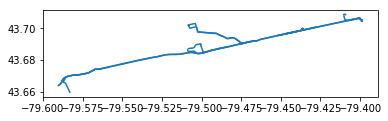

In [15]:

gdf.plot()


And we have a plot of the Eglingtion West 32 route! :)


##### 2.6.2 Map the Stops

Now that we have created a path, lets see if we can place the stops

In [39]:
sql = """
select ds.oid, ds.tag, ds.directiontag, ds.routetag, 
            st_setsrid(st_makepoint(rs.lon::double precision, rs.lat::double precision), 4326) AS stop_geom
from tbl_ttc_dir_stop ds
inner join  tbl_ttc_route_stop rs on rs.tag = ds.tag and ds.routetag = rs.routetag

"""

In [40]:
gdf_stops = getsql_postgis(sql,'stop_geom', db)
gdf_stops.head()

,oid,tag,directiontag,routetag,stop_geom
0,0,6328,5_1_5B,5,POINT (-79.38788 43.6564699)
1,1,10326,5_1_5B,5,POINT (-79.38679 43.6581399)
2,2,7730,5_1_5B,5,POINT (-79.38893 43.6577299)
3,3,8126,5_1_5B,5,POINT (-79.39018 43.65972)
4,4,1920,5_1_5B,5,POINT (-79.39011000000001 43.6610099)


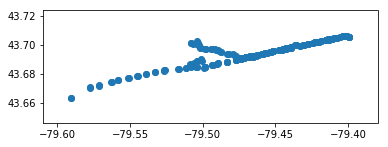

In [18]:
gdf_stops[gdf_stops['routetag']=='32'].plot()

##### 2.6.3 Connecting the Stops with the Paths

Now that we have the path of the route and the position of the stops, we want to find the path between each of the stops.  The 'calc_stop_paths' table is created in the [db_calculations.sql](db_calculations.sql) sql script, you should have run that in section *1 Analysis Setup*, but if you haven't run that yet, do so before you proceed.

The stop path table includes one record for the paths between each stop and the next.

In [19]:
sql = 'select * from calc_stop_paths'
gdf_stoppaths = getsql_postgis(sql,'stop_path_geom', db)
gdf_stoppaths.head()


,oid,tag,directiontag,routetag,stop_geom,prev_stop_geom,stop_path_geom,stop_path_len
0,1,10007,48_1_48,48,0101000020E61000002D095053CBE053C0A5DAA7E331D3...,0101000020E6100000A9BC1DE1B4E053C0BB93F4D5FAD2...,LINESTRING (-79.51103999235293 43.648279900588...,0.002874
1,1,10007,73_1_73B,73,0101000020E61000002D095053CBE053C0A5DAA7E331D3...,0101000020E6100000A297512CB7E053C0919845CDFCD2...,"LINESTRING (-79.51118 43.64834, -79.5111200000...",0.003063
2,1,10007,73_1_73C,73,0101000020E61000002D095053CBE053C0A5DAA7E331D3...,0101000020E6100000A297512CB7E053C0919845CDFCD2...,"LINESTRING (-79.51118 43.64834, -79.5111200000...",0.003063
3,1,10085,322_0_BIWD,322,0101000020E61000002788BA0F40D253C0164D672783D7...,0101000020E61000004E62105839D253C082DF2B5F3CD7...,LINESTRING (-79.28475001481578 43.681529997754...,0.005336
4,1,10085,324_1_324,324,0101000020E61000002788BA0F40D253C0818D902683D7...,0101000020E61000004E62105839D253C082DF2B5F3CD7...,LINESTRING (-79.28475001481578 43.681529997754...,0.005336


In [20]:
%matplotlib agg
fig, ax = plt.subplots()
def animate(ts):
    ax.clear()
    gdf_stoppaths[(gdf_stoppaths['directiontag']=='32_1_32C')].plot(ax=ax,color='blue')
    fgbus_gdf = gdf_stoppaths[(gdf_stoppaths['directiontag']=='32_1_32C') & (gdf_stoppaths['tag']==ts)]
    fgbus_gdf.plot(ax=ax,color='red', linewidth=3)
    ax.axis('equal')


In [21]:
%matplotlib inline

In [22]:
ts = gdf_stoppaths[gdf_stoppaths['directiontag']=='32_1_32C'].tag.tolist()
ani = animation.FuncAnimation(fig, animate, frames=ts)
#ani.save('route32_stop_paths_v3.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

Here we see the 32C West bound line.  The blue part is the whole route, we highlight each of the path segements between stops in order from start (Eastern most stop) to the end (Western most stop) in red.

In [24]:
HTML(ani.to_html5_video())

<Figure size 432x288 with 0 Axes>

##### 2.7 Stop Service Area

Here we will look at the area serviced by each stop.


In [109]:

sql = """
select st_transform((st_dump(st_voronoipolygons(st_collect(stop_geom)))).geom,3857) stop_area_geom
from (select distinct stop_geom from calc_stops_01_locations) sg"""
gdf_stopareas = getsql_postgis(sql,'stop_area_geom', db)

sql = """
select st_transform((st_dump(st_voronoipolygons(st_collect(stop_geom),0.015))).geom,3857) stop_area_geom
from (select distinct stop_geom from calc_stops_01_locations) sg"""
gdf_stopareas_grp = getsql_postgis(sql,'stop_area_geom', db)

sql = "select st_transform(stop_area_geom,3857) stop_area_geom from toronto_streets_03_main_intersections where grp_type = 'not grouped'"
gdf_maj_intersections = getsql_postgis(sql, 'stop_area_geom', db)

sql = "select st_transform(stop_area_geom,3857) stop_area_geom from toronto_streets_03_main_intersections where grp_type = 'grouped'"
gdf_maj_intersections_grp = getsql_postgis(sql, 'stop_area_geom', db)


In [103]:
sql = """
select ds.oid, ds.tag, ds.directiontag, ds.routetag, 
            st_transform(st_setsrid(st_makepoint(rs.lon::double precision, rs.lat::double precision), 4326),3857) AS stop_geom
from tbl_ttc_dir_stop ds
inner join  tbl_ttc_route_stop rs on rs.tag = ds.tag and ds.routetag = rs.routetag

"""

gdf_stops = getsql_postgis(sql, 'stop_geom', db)

In [3]:
tilemapbase.start_logging()

# Don't need if you have run before; DB file will already exist.
tilemapbase.init(create=True)

# Use open street map
t = tilemapbase.tiles.build_OSM()

In [104]:
degree_range = 0.06
extent = tilemapbase.Extent.from_lonlat(-79.4,-79.37,43.65,43.67)
extent = extent.to_aspect(1.0)
extent = extent.to_project_3857()

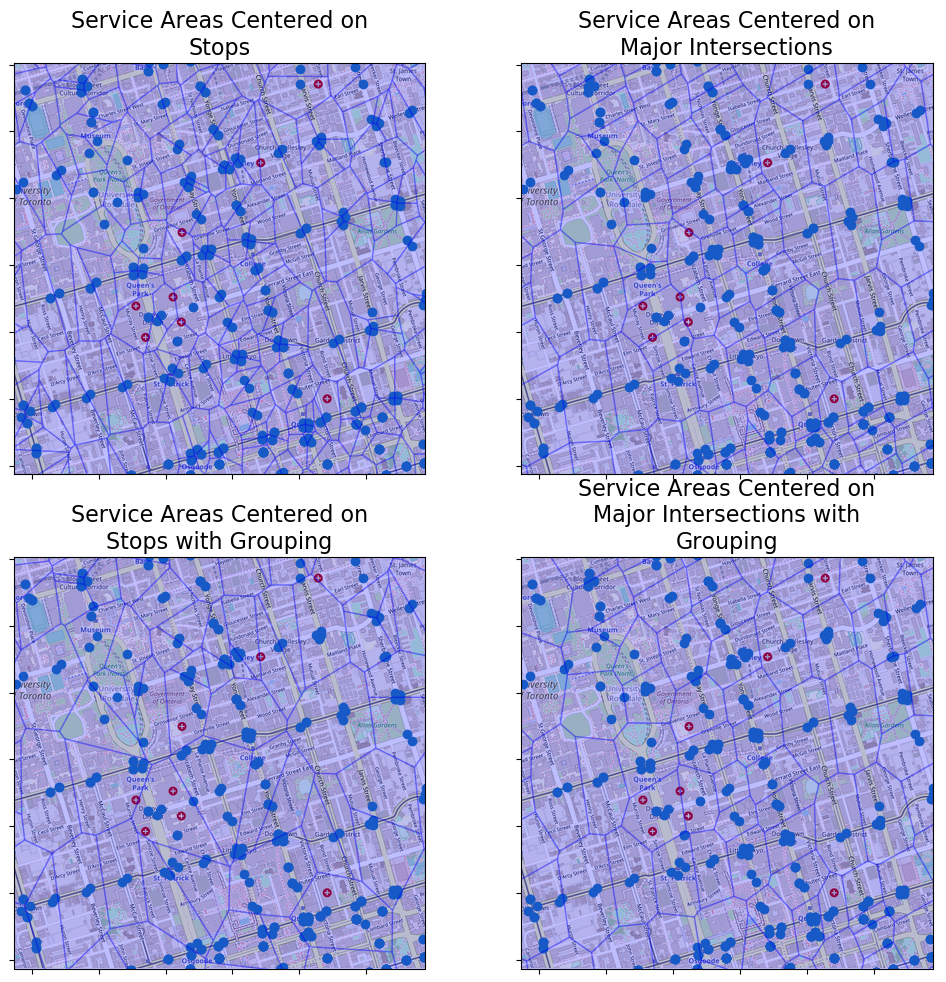

In [131]:
fig, ax = plt.subplots(2,2,figsize=(12, 12), dpi=100)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax[0,0], t)

for poly in gdf_stopareas['stop_area_geom']:
    ax[0,0].add_patch(PolygonPatch(poly, fc='blue', ec='blue', alpha=0.25, zorder = 2))

ax[0,0].set_yticklabels([])
ax[0,0].set_xticklabels([])
title='Service Areas Centered on Stops'
ax[0,0].set_title("\n".join(wrap(title,30)), fontsize=16)

gdf_stops.plot(ax=ax[0,0])

plotter.plot(ax[1,0], t)

for poly in gdf_stopareas_grp['stop_area_geom']:
    ax[1,0].add_patch(PolygonPatch(poly, fc='blue', ec='blue', alpha=0.25, zorder = 2))

ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
title='Service Areas Centered on Stops with Grouping'
ax[1,0].set_title("\n".join(wrap(title,30)), fontsize=16)

gdf_stops.plot(ax=ax[1,0])

plotter.plot(ax[0,1], t)

for poly in gdf_maj_intersections['stop_area_geom']:
    ax[0,1].add_patch(PolygonPatch(poly, fc='blue', ec='blue', alpha=0.25, zorder = 2))

ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
title='Service Areas Centered on Major Intersections'
ax[0,1].set_title("\n".join(wrap(title,30)), fontsize=16)

gdf_stops.plot(ax=ax[0,1])

plotter.plot(ax[1,1], t)

for poly in gdf_maj_intersections_grp['stop_area_geom']:
    ax[1,1].add_patch(PolygonPatch(poly, fc='blue', ec='blue', alpha=0.25, zorder = 2))

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
title='Service Areas Centered on Major Intersections with Grouping'
ax[1,1].set_title("\n".join(wrap(title,30)), fontsize=16)

gdf_stops.plot(ax=ax[1,1])

plt.show()

In the above charts it the service area's centered on major intersections seem to estimate service area's much beter than centering on stops, even when we group closely spaced stops.

Pending work in this section:
* calculate some stats on the Service Areas centered on Major Intersections.. it's not clear whether grouping in this case is an improvement or not
* flag the service areas that are close to a subway station, and by extention the stops that are close to a subway station.  Since subway stops are a major destination for the serface routes, travel times to subway stops are likely a good proxy for service travel times


In the next section we will look at the vehicle location data: [3_Location_Analysis.ipynb](3_Location_Analysis.ipynb)